In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count

from pathlib import Path
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler


import warnings
torch.cuda.set_device(0)
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv('Train-dataset.csv')

In [4]:
lithology_color = {100: '#997950',
                    200: '#cccccc',
                    300: '#ffff00',
                    400: '#ffccff',
                    500: '#006600',
                    600: '#666600',
                    700: '#F8DE7E',
                    800: '#999DA0',
                    900: '#9933ff',
                    1000: '#ff6600',
                    1100: '#000000',
                    1200: '#98FB98',
                    1300: '#ff9999',
                    1400: '#CEB180',
                    1500: '#3BB143'
                    }

lithology_key = {100: 'Clay',
                 200: 'Siltstone/Loess',
                 300: 'Marl',
                 400: 'Clay marl',
                 500: 'Clay sandstone',
                 600: 'Sandstone',
                 700: 'Limestone',
                 800: 'Tight',
                 900: 'Dolomite',
                 1000: 'Coal',
                 1100: 'Coal clay',
                 1200: 'Marly sandstone',
                 1300: 'Sandy marl',
                 1400: 'Marl clay',
                 1500: 'Siltstone clay'
                  }

In [5]:
def autolabel(ax, bars, labels):
    """Attach a text label above each bar."""
    for bar, label in zip(bars, labels):
        height = bar.get_height()
        ax.annotate('{}'.format(label),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [6]:
MAPPING = {
    'Continental': 1,
    'Transitional': 2,
    'Marine': 3,
}

df['D_Env']=df['DEPOSITIONAL_ENVIRONMENT'].apply(lambda x: MAPPING[x])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45749 entries, 0 to 45748
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WELL                      45749 non-null  object 
 1   X                         45749 non-null  float64
 2   Y                         45749 non-null  float64
 3   MD                        45749 non-null  float64
 4   GR                        45749 non-null  float64
 5   RT                        45749 non-null  float64
 6   CN                        45749 non-null  float64
 7   DEN                       45749 non-null  float64
 8   DEPOSITIONAL_ENVIRONMENT  45749 non-null  object 
 9   LITH_NAME                 45749 non-null  object 
 10  LITH_CODE                 45749 non-null  int64  
 11  D_Env                     45749 non-null  int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 4.2+ MB


In [7]:
df['new'] = df['LITH_CODE'] + df['D_Env']
print(df['new'].unique())

[1203 1303  603 1101 1401 1201 1102 1302 1202  102 1502 1402  802  602
  502  302  402 1503  803  203  403  503  303 1002  801 1001  101  501
  601 1301  401  301  103 1103 1403]


In [8]:
df_train = df


"for val in df['LITH_CODE'].unique():\n    rows = df.loc[df['LITH_CODE'] == val]\n    new_rows = rows\n    \n    for dep in rows['DEPOSITIONAL_ENVIRONMENT'].unique():\n        rows_dep_env = rows.loc[rows['DEPOSITIONAL_ENVIRONMENT'] == dep]\n        if(rows_dep_env.shape[0] < 1000 and rows.shape[0] < 3000):\n            num_of_duplicates = int((1000 -  rows_dep_env.shape[0]) / rows_dep_env.shape[0]) + 1\n            temp = pd.concat([rows_dep_env] * num_of_duplicates,ignore_index=False)\n            \n            mean = (rows_dep_env['GR'].max() + rows_dep_env['GR'].min()) / 2\n            std = (rows_dep_env['GR'].max() - rows_dep_env['GR'].min()) / 100\n            num_samples = temp.shape[0]\n            samples = np.random.normal(mean, std, size=num_samples)\n            temp['series_gr'] = samples\n            temp['GR'] = temp['GR'] + temp['series_gr']\n            \n            mean = (rows_dep_env['RT'].max() + rows_dep_env['RT'].min()) / 2\n            std = (rows_dep_env['RT'

In [9]:
Feature = df_train[['GR', 'RT', 'DEN', 'CN','D_Env']]

In [10]:
X = Feature
X = preprocessing.StandardScaler().fit(X).transform(X)

In [11]:
y = df['LITH_CODE']


In [88]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
clf = RandomForestClassifier(random_state=0, n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [110]:
model = GradientBoostingClassifier(random_state=0, n_estimators=100)
model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=0)

In [111]:
y_pred=model.predict(X_test)
y_pred

array([1300,  600,  500, ..., 1100,  600, 1000], dtype=int64)

In [112]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Test set accuracy: ", round(metrics.f1_score(y_test, y_pred, average = 'micro'), 3))

Accuracy: 0.8330054644808743
Test set accuracy:  0.833


In [116]:
test_dataset = pd.read_csv('Test-dataset.csv')
test_dataset['D_Env']=test_dataset['DEPOSITIONAL_ENVIRONMENT'].apply(lambda x: MAPPING[x])
test_feature = test_dataset[['GR', 'RT', 'DEN', 'CN','D_Env']]

df_old_sub = pd.read_csv('submission_first.csv')
df_old_sub = df_old_sub['LITH_CODE']

print("Accuracy:",metrics.accuracy_score(df_old_sub, model.predict(test_feature)))
print("Test set accuracy: ", round(metrics.f1_score(df_old_sub, model.predict(test_feature), average = 'micro'), 3))

Accuracy: 0.010104493568300168
Test set accuracy:  0.01


In [55]:
test_dataset = pd.read_csv('Test-dataset.csv')
test_dataset['D_Env']=test_dataset['DEPOSITIONAL_ENVIRONMENT'].apply(lambda x: MAPPING[x])
test_feature = test_dataset[['GR', 'RT', 'DEN', 'CN','D_Env']]

In [56]:
pred = clf.predict(test_feature)
pred = torch.tensor(pred)
y = torch.tensor(y)

In [57]:
with torch.no_grad():

    predicted = torch.max(pred)
    correct = (predicted == y).sum().item()
    print(correct / test_dataset.shape[0])

0.2777528709866538


In [174]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [175]:
df

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_NAME,LITH_CODE,D_Env,new
0,Well-1,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,Marine,Marly sandstone,1200,3,1203
1,Well-1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,Marine,Marly sandstone,1200,3,1203
2,Well-1,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,Marine,Marly sandstone,1200,3,1203
3,Well-1,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,Marine,Sandy marl,1300,3,1303
4,Well-1,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,Marine,Sandy marl,1300,3,1303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45744,Well-10,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,Marine,Clay marl,400,3,403
45745,Well-10,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,Marine,Clay marl,400,3,403
45746,Well-10,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,Marine,Clay marl,400,3,403
45747,Well-10,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,Marine,Clay marl,400,3,403


# Validate your model

In [176]:
test_dataset = pd.read_csv('Test-dataset.csv')

display(test_dataset.info())
display(test_dataset.head(5))
display(test_dataset.tail(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28997 entries, 0 to 28996
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        28997 non-null  int64  
 1   WELL                      28997 non-null  object 
 2   X                         28997 non-null  float64
 3   Y                         28997 non-null  float64
 4   MD                        28997 non-null  float64
 5   GR                        28997 non-null  float64
 6   RT                        28997 non-null  float64
 7   CN                        28997 non-null  float64
 8   DEN                       28997 non-null  float64
 9   DEPOSITIONAL_ENVIRONMENT  28997 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 2.2+ MB


None

,Id,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT
0,1,Well-X,2.9956,0.0061,897.065,92.7094,4.51768,0.36366,2.2106,Continental
1,2,Well-X,2.9956,0.0061,897.165,93.9007,4.30683,0.36951,2.2036,Continental
2,3,Well-X,2.9956,0.0061,897.265,94.8446,3.98902,0.37914,2.1969,Continental
3,4,Well-X,2.9956,0.0061,897.365,95.6321,3.67028,0.39020,2.1923,Continental
4,5,Well-X,2.9956,0.0061,897.465,96.4700,3.63431,0.40098,2.1926,Continental


,Id,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT
28992,28993,Well-Z,1.1475,2.6893,1717.8,108.7532,2.1883,0.31751,2.4094,Marine
28993,28994,Well-Z,1.1475,2.6893,1717.9,108.0650,2.2162,0.31582,2.4125,Marine
28994,28995,Well-Z,1.1475,2.6893,1718.0,108.0439,2.2522,0.31304,2.4150,Marine
28995,28996,Well-Z,1.1475,2.6893,1718.1,108.6799,2.3058,0.30963,2.4175,Marine
28996,28997,Well-Z,1.1475,2.6893,1718.2,109.4661,2.3896,0.30532,2.4210,Marine


In [177]:
test_dataset['D_Env']=test_dataset['DEPOSITIONAL_ENVIRONMENT'].apply(lambda x: MAPPING[x])

In [178]:
test_dataset

,Id,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,D_Env
0,1,Well-X,2.9956,0.0061,897.065,92.7094,4.51768,0.36366,2.2106,Continental,1
1,2,Well-X,2.9956,0.0061,897.165,93.9007,4.30683,0.36951,2.2036,Continental,1
2,3,Well-X,2.9956,0.0061,897.265,94.8446,3.98902,0.37914,2.1969,Continental,1
3,4,Well-X,2.9956,0.0061,897.365,95.6321,3.67028,0.39020,2.1923,Continental,1
4,5,Well-X,2.9956,0.0061,897.465,96.4700,3.63431,0.40098,2.1926,Continental,1
...,...,...,...,...,...,...,...,...,...,...,...
28992,28993,Well-Z,1.1475,2.6893,1717.800,108.7532,2.18830,0.31751,2.4094,Marine,3
28993,28994,Well-Z,1.1475,2.6893,1717.900,108.0650,2.21620,0.31582,2.4125,Marine,3
28994,28995,Well-Z,1.1475,2.6893,1718.000,108.0439,2.25220,0.31304,2.4150,Marine,3
28995,28996,Well-Z,1.1475,2.6893,1718.100,108.6799,2.30580,0.30963,2.4175,Marine,3


In [179]:
test_feature = test_dataset[['GR', 'RT', 'DEN', 'CN','D_Env']]

In [180]:
# Testing feature
X_test = test_feature

# Normalizing Test Data
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [ ]:
# Pkl_Filename = "KNN_Model.pkl"

# with open(Pkl_Filename, 'rb') as file:  
#     model = pickle.load(file)

In [ ]:
test_yhat

In [ ]:
test_dataset['LITH_CODE'] = test_yhat

In [181]:
test_dataset

,Id,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,D_Env
0,1,Well-X,2.9956,0.0061,897.065,92.7094,4.51768,0.36366,2.2106,Continental,1
1,2,Well-X,2.9956,0.0061,897.165,93.9007,4.30683,0.36951,2.2036,Continental,1
2,3,Well-X,2.9956,0.0061,897.265,94.8446,3.98902,0.37914,2.1969,Continental,1
3,4,Well-X,2.9956,0.0061,897.365,95.6321,3.67028,0.39020,2.1923,Continental,1
4,5,Well-X,2.9956,0.0061,897.465,96.4700,3.63431,0.40098,2.1926,Continental,1
...,...,...,...,...,...,...,...,...,...,...,...
28992,28993,Well-Z,1.1475,2.6893,1717.800,108.7532,2.18830,0.31751,2.4094,Marine,3
28993,28994,Well-Z,1.1475,2.6893,1717.900,108.0650,2.21620,0.31582,2.4125,Marine,3
28994,28995,Well-Z,1.1475,2.6893,1718.000,108.0439,2.25220,0.31304,2.4150,Marine,3
28995,28996,Well-Z,1.1475,2.6893,1718.100,108.6799,2.30580,0.30963,2.4175,Marine,3


In [ ]:
submission.to_csv('submission.csv', index=False)

In [245]:
ID_COLS = ['Id', 'WELL', 'X', 'Y', 'DEPOSITIONAL_ENVIRONMENT', 'LITH_CODE', 'new']

def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X = Feature
    X = preprocessing.StandardScaler().fit(X).transform(X)
    X_grouped = X
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc


def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    #X_grouped = np.row_stack([
    #    group.drop(columns=drop_cols).values[None]
    #    for _, group in X.groupby('series_id')])
    X_test = test_feature

    # Normalizing Test Data
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    X_grouped = torch.tensor(X_test.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [183]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    

In [184]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

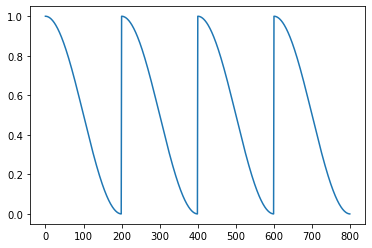

In [234]:
n = 200
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [235]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [236]:
y_col = df_train.iloc[:, [10]]
df

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_NAME,LITH_CODE,D_Env,new
0,Well-1,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,Marine,Marly sandstone,1200,3,1203
1,Well-1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,Marine,Marly sandstone,1200,3,1203
2,Well-1,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,Marine,Marly sandstone,1200,3,1203
3,Well-1,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,Marine,Sandy marl,1300,3,1303
4,Well-1,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,Marine,Sandy marl,1300,3,1303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45744,Well-10,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,Marine,Clay marl,400,3,403
45745,Well-10,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,Marine,Clay marl,400,3,403
45746,Well-10,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,Marine,Clay marl,400,3,403
45747,Well-10,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,Marine,Clay marl,400,3,403


In [241]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [242]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(principalDf, y_col)

Preparing datasets


In [243]:
bs = 16
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=0)


Creating data loaders with batch size: 16


In [ ]:
input_dim = 2   
hidden_dim = 256
layer_dim = 4
output_dim = 13
seq_dim = 128

lr = 0.001
n_epochs = 100
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = torch.reshape(x_batch, (x_batch.shape[0], 1, x_batch.shape[1]))
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
        x_val = torch.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_lstm_balanced_v3.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


In [ ]:
input_dim = 6    
hidden_dims = [8, 32, 64, 128, 256, 512]
layer_dims = [3, 4]
output_dim = 13
seq_dim = 128

print('Start model training')

for hidden_dim in hidden_dims:
    for layer_dim in layer_dims:
        
        trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=0)
        
        lr = 0.001
        n_epochs = 50
        iterations_per_epoch = len(trn_dl)
        best_acc = 0
        patience, trials = 100, 0
        
        model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
        model = model.cuda()
        criterion = nn.CrossEntropyLoss()
        opt = torch.optim.RMSprop(model.parameters(), lr=lr)
        sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

        for epoch in range(1, n_epochs + 1):

            for i, (x_batch, y_batch) in enumerate(trn_dl):
                model.train()
                x_batch = torch.reshape(x_batch, (x_batch.shape[0], 1, x_batch.shape[1]))
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
                sched.step()
                opt.zero_grad()
                out = model(x_batch)
                loss = criterion(out, y_batch)
                loss.backward()
                opt.step()

            model.eval()
            correct, total = 0, 0
            for x_val, y_val in val_dl:
                x_val = torch.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
                x_val, y_val = [t.cuda() for t in (x_val, y_val)]
                out = model(x_val)
                preds = F.log_softmax(out, dim=1).argmax(dim=1)
                total += y_val.size(0)
                correct += (preds == y_val).sum().item()

            acc = correct / total

            if acc > best_acc:
                trials = 0
                best_acc = acc
                torch.save(model.state_dict(), 'best_lstm_balanced1.pth')
                
        print(hidden_dim, layer_dim, best_acc)

In [ ]:
input_dim = 6    
hidden_dim = 256
layer_dim = 3
output_dim = 13
seq_dim = 128

lr = 0.001
n_epochs = 1000
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))
model.load_state_dict(torch.load('best_lstm_balanced.pth'))

In [192]:
model.load_state_dict(torch.load('best_lstm_balanced_v3.pth'))
model.eval()


LSTMClassifier(
  (rnn): LSTM(5, 512, num_layers=4, batch_first=True)
  (fc): Linear(in_features=512, out_features=13, bias=True)
)

In [ ]:
torch.save(model.state_dict(), 'best_lstm_balanced_initial.pth')

    

In [195]:
print("Test set accuracy: ", round(metrics.f1_score(final_labels, final, average = 'micro'), 25))

Test set accuracy:  0.8710382513661202


In [ ]:
sub = final.copy()
for ind in range(len(final)):
    sub[ind] = enc.classes_[final[ind]]
    
submission = pd.DataFrame(sub, columns = ['LITH_CODE'])
submission.to_csv('submission.csv', index=False)

In [196]:
def create_test_dataset(X, drop_cols=ID_COLS):
    #X_grouped = np.row_stack([
    #    group.drop(columns=drop_cols).values[None]
    #    for _, group in X.groupby('series_id')])
    X_test = test_feature

    # Normalizing Test Data
    X_grouped = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    X_grouped = torch.tensor(X_grouped).float()
    y_fake = torch.tensor([0] * X_grouped.shape[0]).long()
    
    testdataset = TensorDataset(X_grouped, y_fake)
    return testdataset

In [197]:
tst_ds = create_test_dataset(test_dataset)
tst_dl = DataLoader(tst_ds, bs, shuffle=False, num_workers=0)

In [198]:
with torch.no_grad():
    final = []
    for x_val, labels in tst_dl:
        x_val = x_val.to(device)
        x_val = torch.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
        labels = labels.to(device)
        outputs = model(x_val)
        _, predicted = torch.max(outputs.data, 1)
        final.extend(predicted.tolist())
        

In [199]:
sub = final.copy()
for ind in range(len(final)):
    
    sub[ind] = enc.classes_[final[ind]]
    
submission = pd.DataFrame(sub, columns = ['LITH_CODE'])
submission.to_csv('submission_lstm_balanced_v3.csv', index=False)

In [102]:
df_old_sub = pd.read_csv('xgb_v2.csv')
bla = pd.read_csv('submission_first.csv')
df_old_sub = df_old_sub['LITH_CODE']
new_sub = bla['LITH_CODE']

In [103]:
sum = 0
for i in range(df_old_sub.shape[0]):
    sum += df_old_sub[i] == new_sub[i]
    
print(sum/df_old_sub.shape[0])

0.6562403007207642
